In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tabular-playground-series-aug-2022/sample_submission.csv
/kaggle/input/tabular-playground-series-aug-2022/train.csv
/kaggle/input/tabular-playground-series-aug-2022/test.csv


In [2]:
train = pd.read_csv('/kaggle/input/tabular-playground-series-aug-2022/train.csv')
test = pd.read_csv('/kaggle/input/tabular-playground-series-aug-2022/test.csv')
print('train', train.shape)
print('test', test.shape)

train (26570, 26)
test (20775, 25)


In [7]:
!pip install pycaret --ignore-installed llvmlite

  Using cached pycaret-2.3.10-py3-none-any.whl (320 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.6/34.6 MB 15.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 292.8/292.8 kB 21.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.7/81.7 kB 7.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.0/307.0 kB 23.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.2/15.2 MB 22.3 MB/s eta 0:00:0000:0100:01
  Using cached mlflow-1.28.0-py3-none-any.whl (17.0 MB)
  Using cached PyYAML-5.4.1-cp37-cp37m-manylinux1_x86_64.whl (636 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 50.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 636.8/636.8 kB 32.8 MB/s eta 0:00:00
     ━━━━━━━━━━

In [8]:
from pycaret.classification import *

In [9]:
train.columns

Index(['id', 'product_code', 'loading', 'attribute_0', 'attribute_1',
       'attribute_2', 'attribute_3', 'measurement_0', 'measurement_1',
       'measurement_2', 'measurement_3', 'measurement_4', 'measurement_5',
       'measurement_6', 'measurement_7', 'measurement_8', 'measurement_9',
       'measurement_10', 'measurement_11', 'measurement_12', 'measurement_13',
       'measurement_14', 'measurement_15', 'measurement_16', 'measurement_17',
       'failure'],
      dtype='object')

In [11]:
train.describe(include = ['category', 'object'])

,product_code,attribute_0,attribute_1
count,26570,26570,26570
unique,5,2,3
top,C,material_7,material_8
freq,5765,21320,10865


In [12]:
train.head()

,id,product_code,loading,attribute_0,attribute_1,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,...,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17,failure
0,0,A,80.10,material_7,material_8,9,5,7,8,4,...,10.672,15.859,17.594,15.193,15.029,NaN,13.034,14.684,764.100,0
1,1,A,84.89,material_7,material_8,9,5,14,3,3,...,12.448,17.947,17.915,11.755,14.732,15.425,14.395,15.631,682.057,0
2,2,A,82.43,material_7,material_8,9,5,12,1,5,...,12.715,15.607,NaN,13.798,16.711,18.631,14.094,17.946,663.376,0
3,3,A,101.07,material_7,material_8,9,5,13,2,6,...,12.471,16.346,18.377,10.020,15.250,15.562,16.154,17.172,826.282,0
4,4,A,188.06,material_7,material_8,9,5,9,2,8,...,10.337,17.082,19.932,12.428,16.182,12.760,13.153,16.412,579.885,0


In [18]:
clf_1 = setup(data = train, target = 'failure', session_id = 100, categorical_features = ['product_code', 'attribute_0', 'attribute_1'],
             numeric_features = ['id', 'loading',
       'attribute_2', 'attribute_3', 'measurement_0', 'measurement_1',
       'measurement_2', 'measurement_3', 'measurement_4', 'measurement_5',
       'measurement_6', 'measurement_7', 'measurement_8', 'measurement_9',
       'measurement_10', 'measurement_11', 'measurement_12', 'measurement_13',
       'measurement_14', 'measurement_15', 'measurement_16', 'measurement_17'],
             train_size = 0.15) # session_id equivalent to random_state

,Description,Value
0,session_id,100
1,Target,failure
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(26570, 26)"
5,Missing Values,True
6,Numeric Features,22
7,Categorical Features,3
8,Ordinal Features,False
9,High Cardinality Features,False


In [21]:
best_model = compare_models(sort = 'AUC')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.7922,0.5630,0.0000,0.0000,0.0000,-0.0005,-0.0026,0.0270
lda,Linear Discriminant Analysis,0.7922,0.5458,0.0012,0.0333,0.0024,0.0009,0.0027,0.0170
catboost,CatBoost Classifier,0.7917,0.5349,0.0012,0.1000,0.0024,-0.0001,-0.0005,5.0030
gbc,Gradient Boosting Classifier,0.7862,0.5348,0.0048,0.0983,0.0092,-0.0067,-0.0213,0.8880
et,Extra Trees Classifier,0.7922,0.5282,0.0000,0.0000,0.0000,-0.0005,-0.0026,0.4530
lightgbm,Light Gradient Boosting Machine,0.7854,0.5259,0.0327,0.3864,0.0592,0.0229,0.0497,0.1410
nb,Naive Bayes,0.7859,0.5252,0.0290,0.3472,0.0532,0.0200,0.0429,0.0110
xgboost,Extreme Gradient Boosting,0.7754,0.5209,0.0495,0.2778,0.0838,0.0216,0.0330,0.7970
rf,Random Forest Classifier,0.7917,0.5188,0.0012,0.0500,0.0024,-0.0001,-0.0026,0.7550
ada,Ada Boost Classifier,0.7847,0.5175,0.0121,0.1965,0.0225,-0.0013,-0.0003,0.2530


In [22]:
print(best_model)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=100, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


In [23]:
lr = create_model('lr')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7920,0.5777,0.0000,0.0000,0.0000,0.0000,0.0000
1,0.7920,0.5271,0.0000,0.0000,0.0000,0.0000,0.0000
2,0.7920,0.5637,0.0000,0.0000,0.0000,0.0000,0.0000
3,0.7920,0.5988,0.0000,0.0000,0.0000,0.0000,0.0000
4,0.7920,0.5655,0.0000,0.0000,0.0000,0.0000,0.0000
5,0.7940,0.5664,0.0000,0.0000,0.0000,0.0000,0.0000
6,0.7915,0.5476,0.0000,0.0000,0.0000,-0.0050,-0.0256
7,0.7940,0.5600,0.0000,0.0000,0.0000,0.0000,0.0000
8,0.7915,0.5265,0.0000,0.0000,0.0000,0.0000,0.0000


In [24]:
print(lr)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=100, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


In [25]:
tuned_lr = tune_model(lr)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7920,0.5777,0.0000,0.0000,0.0000,0.0000,0.0000
1,0.7920,0.5271,0.0000,0.0000,0.0000,0.0000,0.0000
2,0.7920,0.5554,0.0000,0.0000,0.0000,0.0000,0.0000
3,0.7920,0.5987,0.0000,0.0000,0.0000,0.0000,0.0000
4,0.7920,0.5629,0.0000,0.0000,0.0000,0.0000,0.0000
5,0.7940,0.5287,0.0000,0.0000,0.0000,0.0000,0.0000
6,0.7915,0.5476,0.0000,0.0000,0.0000,-0.0050,-0.0256
7,0.7940,0.5600,0.0000,0.0000,0.0000,0.0000,0.0000
8,0.7915,0.5284,0.0000,0.0000,0.0000,0.0000,0.0000


In [26]:
print(tuned_lr)

LogisticRegression(C=7.074000000000001, class_weight={}, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=1000, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=100, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


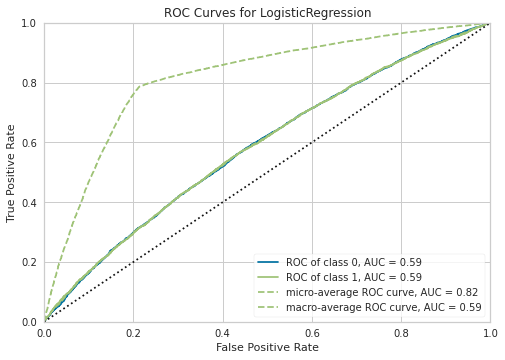

In [27]:
plot_model(tuned_lr, plot = 'auc')

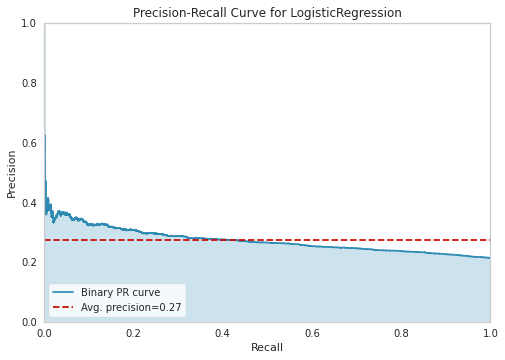

In [28]:
plot_model(tuned_lr, 'pr')

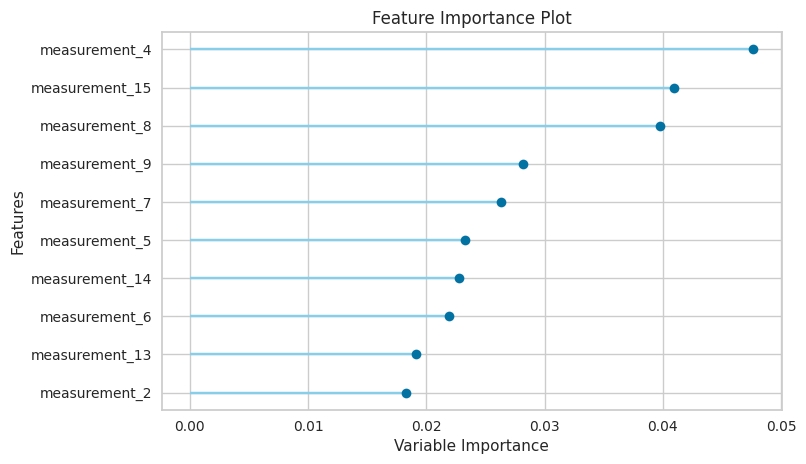

In [32]:
plot_model(tuned_lr, plot = 'feature')

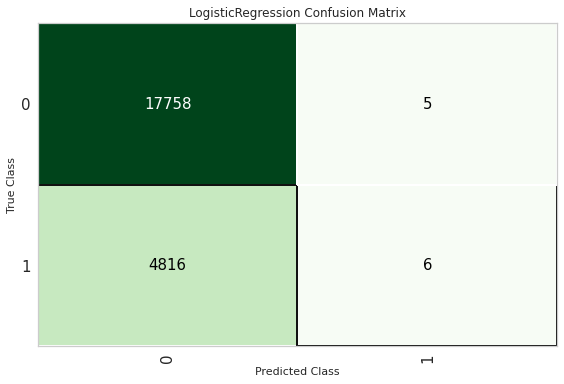

In [33]:
plot_model(tuned_lr, plot = 'confusion_matrix')

In [35]:
evaluate_model(tuned_lr)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

In [37]:
# predictions on validation set
predict_model(tuned_lr)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.7865,0.5865,0.0012,0.5455,0.0025,0.0015,0.0179


,id,loading,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,measurement_3,measurement_4,measurement_5,...,product_code_A,product_code_C,product_code_D,product_code_E,attribute_0_material_5,attribute_1_material_5,attribute_1_material_8,failure,Label,Score
0,26016.0,57.410000,6.0,9.0,4.0,9.0,4.0,18.260000,11.725277,16.908001,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0,0.8618
1,10089.0,108.430000,8.0,8.0,11.0,13.0,5.0,19.396000,11.997000,17.097000,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1,0,0.8354
2,8762.0,125.839996,8.0,8.0,6.0,12.0,9.0,18.256001,11.674000,16.593000,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1,0,0.8052
3,573.0,81.160004,9.0,5.0,8.0,4.0,5.0,19.180000,11.560000,19.316000,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0,0.8441
4,14462.0,151.199997,5.0,8.0,5.0,7.0,1.0,17.731001,11.495000,18.098000,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0,0,0.7265
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22580,15700.0,171.479996,5.0,8.0,2.0,8.0,5.0,17.214001,11.685000,15.003000,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0,0,0.7337
22581,10051.0,234.660004,8.0,8.0,6.0,8.0,5.0,16.193001,9.484000,18.951000,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0,0,0.6254
22582,23509.0,117.800003,6.0,9.0,5.0,8.0,10.0,18.921000,11.437000,17.577000,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0,0.8069
22583,14300.0,196.320007,5.0,8.0,9.0,12.0,1.0,17.483999,10.317000,18.058001,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1,0,0.7206


In [38]:
final_lr =finalize_model(tuned_lr)

In [39]:
print(final_lr)

LogisticRegression(C=7.074000000000001, class_weight={}, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=1000, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=100, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


In [40]:
predictions = predict_model(final_lr, data = test)
predictions.head()

,id,product_code,loading,attribute_0,attribute_1,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,...,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17,Label,Score
0,26570,F,119.57,material_5,material_6,6,4,6,9,6,...,15.909,18.070,13.772,13.659,16.825,13.742,17.710,634.612,0,0.8117
1,26571,F,113.51,material_5,material_6,6,4,11,8,0,...,13.998,NaN,12.473,17.468,16.708,14.776,14.102,537.037,0,0.8270
2,26572,F,112.16,material_5,material_6,6,4,8,12,4,...,17.046,18.086,10.907,13.363,15.737,17.065,16.021,658.995,0,0.8160
3,26573,F,112.72,material_5,material_6,6,4,8,11,10,...,18.165,16.163,10.933,15.501,15.667,12.620,16.111,594.301,0,0.8153
4,26574,F,208.00,material_5,material_6,6,4,14,16,8,...,14.578,17.849,11.941,16.070,16.183,13.324,17.150,801.044,0,0.6771


In [42]:
submission = pd.DataFrame()
submission['id'] = test['id']
submission['failure'] = predictions['Label']
submission.to_csv("submission.csv", index = False)